In [9]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pd
from skimage import metrics
from tqdm import tqdm

In [51]:
data = sio.loadmat(r'Models/FluctuationFixed/Spinning/test_processed.mat')
unet = data['recon2']
smoothed = data['smooth_images']
unsmoothed = data['noisy_images']
ground_truth = data['clean_images']
mask = data['mask']

With MRI used as the optimal measurement the rest of the metrics are calculated based on that being ground truth

In [52]:
df = pd.DataFrame(columns=['unet_mse', 'unet_ssim', 'smoothed_mse', 'smoothed_ssim', 'unsmoothed_mse', 'unsmoothed_ssim'])
df

,unet_mse,unet_ssim,smoothed_mse,smoothed_ssim,unsmoothed_mse,unsmoothed_ssim


In [53]:
def mse(input, target, mask):
    """
    returns the array of the mean squared error of the input vs target
    :param input: array
    :param target: array
    :return: 
    """
    return np.sum(np.subtract(input, target) ** 2, axis=tuple([0, 1, 2]))

def ssim(input, target):
    """
    return the array of SSIM of the input vs target
    :param input: 
    :param target: 
    :return: 
    """
    ssim = []
    for i in range(input.shape[-1]):
        ssim.append(metrics.structural_similarity(target[:,:,:,i],input[:,:,:,i]))
    return np.array(ssim)

In [ ]:
for i in tqdm(range(ground_truth.shape[-1])):
        smoothed[...,i] = smoothed[...,i] * mask
        unsmoothed[...,i] = unsmoothed[...,i] * mask
        unet[...,i] = unet[...,i] * mask

In [54]:
df['smoothed_mse'] = mse(smoothed, ground_truth, mask) 
df['smoothed_ssim'] = ssim(smoothed, ground_truth)
df['unsmoothed_mse'] = mse(unsmoothed, ground_truth, mask)
df['unsmoothed_ssim'] = ssim(unsmoothed, ground_truth)
df['unet_mse'] = mse(unet, ground_truth, mask)
df['unet_ssim'] = ssim(unet, ground_truth)

<ipython-input-53-2372673be574>:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim.append(metrics.structural_similarity(target[:,:,:,i],input[:,:,:,i]))


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   unet_mse         36 non-null     float64
 1   unet_ssim        36 non-null     float64
 2   smoothed_mse     36 non-null     float64
 3   smoothed_ssim    36 non-null     float64
 4   unsmoothed_mse   36 non-null     float64
 5   unsmoothed_ssim  36 non-null     float64
dtypes: float64(6)
memory usage: 1.8 KB


In [56]:
df.head()

,unet_mse,unet_ssim,smoothed_mse,smoothed_ssim,unsmoothed_mse,unsmoothed_ssim
0,25545.223991,0.452554,156094.253032,0.432567,256334.550072,0.326940
1,28100.612279,0.516917,158336.273654,0.436747,182577.855281,0.348324
2,30085.673952,0.455728,151804.159364,0.443424,250780.183188,0.325462
3,30493.880410,0.565625,149341.371163,0.452537,137115.723956,0.381314
4,28050.874391,0.453432,150773.886348,0.476758,225301.995774,0.321487


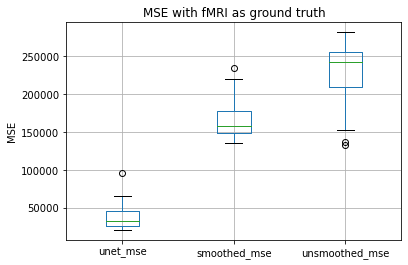

In [57]:
plt.figure()
df.boxplot(column=['unet_mse', 'smoothed_mse', 'unsmoothed_mse'])
plt.ylabel('MSE')
plt.title('MSE with fMRI as ground truth')
plt.show()

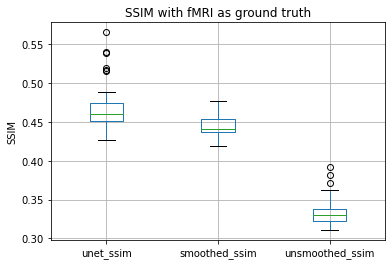

In [58]:
plt.figure()
df.boxplot(column=['unet_ssim', 'smoothed_ssim', 'unsmoothed_ssim'])
plt.ylabel('SSIM')
plt.title('SSIM with fMRI as ground truth')
plt.show()

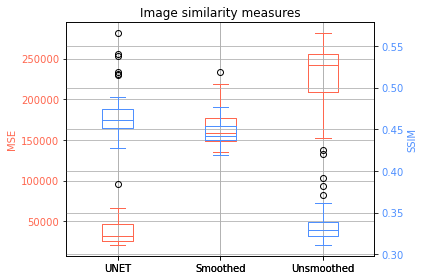

In [59]:
fig, ax1 = plt.subplots()

colour1 = '#FF674F'
ax1.set_title('Image similarity measures')
#ax1.set_xlabel('MSE')
df.boxplot(column=['unet_mse', 'smoothed_mse', 'unsmoothed_mse'], color=colour1)
ax1.tick_params(axis='y', labelcolor=colour1)
ax1.set_ylabel('MSE', color=colour1)

ax2 = ax1.twinx()
colour2 = '#4F90FF'
df.boxplot(column=['unet_ssim', 'smoothed_ssim', 'unsmoothed_ssim'], color=colour2)
ax2.set_ylabel('SSIM', color=colour2)
ax2.tick_params(axis='y', labelcolor=colour2)
ax2.set_xticklabels(['','','', 'UNET', 'Smoothed', 'Unsmoothed'])
fig.tight_layout()
plt.savefig('Image Similarity Measures.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [66]:
images_per_OP = 36
optical_property_changes = np.arange(-10, 11)

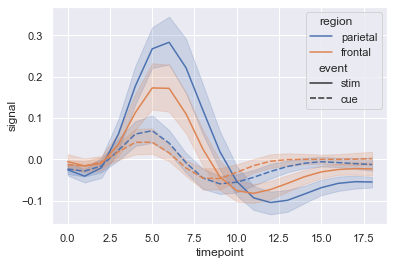

In [69]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)
plt.show()

In [70]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


In [92]:
df2 = pd.DataFrame(columns=['OPchange', 'MSE', 'ReconstructionMethod'])
recon_method = ['unet_mse', 'smoothed_mse', 'unsmoothed_mse']
for recon in recon_method:
    for [i, x] in enumerate(optical_property_changes):
        df3 = pd.DataFrame({'OPchange' : x*np.ones(images_per_OP), 'MSE' : df[recon][i*images_per_OP:images_per_OP*(1+i)], 'ReconstructionMethod' : [recon]*images_per_OP})
        df2 = pd.concat([df2, df3])

ValueError: array length 36 does not match index length 0

In [ ]:


for i,x in enumerate(optical_property_changes):
    




plt.plot()

In [90]:
for [i, x] in enumerate(['a', 'a']):
    print(i, x)

0 a
1 a
